In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("..")
from model import run_experiments
from model.config.params import build_params
import numpy as np

df, simulation_kpis = run_experiments(["Base", "Base"])


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 730, 128, 2, 25)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 64, 1, 25)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (365, 64, 1, 25)
Execution Method: local_simulations
Execution Mode: parallelized
2023-12-16 16:07:14.819231
2023-12-16 16:07:14.824685
Total execution time: 26.46s


In [8]:
df.groupby("key")["POKT_burned"].expanding().sum().reset_index(drop=True)

0      0.000000e+00
1      3.992505e+09
2      9.043889e+09
3      1.392881e+10
4      2.023304e+10
           ...     
727    3.835148e+12
728    3.845603e+12
729    3.855900e+12
730    3.866487e+12
731    3.877120e+12
Name: POKT_burned, Length: 732, dtype: float64

In [6]:
df.groupby('key')[['kpi_a']].mean()

,kpi_a
key,
0-0-1,1.0
1-0-1,1.0


In [5]:
simulation_kpis.columns

Index(['Net Minting Rate', 'KPI C', 'Experiment Name', 'State Set',
       'Params Set', 'timestep', 'param_minimum_stake_servicer',
       'param_minimum_stake_period_servicer', 'param_minimum_pause_time',
       'param_max_chains_servicer', 'param_relays_to_tokens_multiplier',
       'param_slash_fraction_downtime', 'param_downtime_jail_duration',
       'param_minimum_servicers_per_session',
       'param_maximum_servicers_per_session',
       'param_application_fee_per_relay', 'param_minimum_application_stake',
       'param_app_burn_per_session', 'param_app_burn_per_relay',
       'param_block_proposer_allocation', 'param_dao_allocation',
       'param_servicer_allocation', 'param_stake_per_app_delegation',
       'param_gateway_fee_per_relay', 'param_gateway_minimum_stake',
       'param_session_token_bucket_coefficient', 'param_dao_fee_percentage',
       'param_validator_fee_percentage', 'param_transaction_fee',
       'param_application_max_number', 'param_servicer_max_number'

## Basic Line Graphs

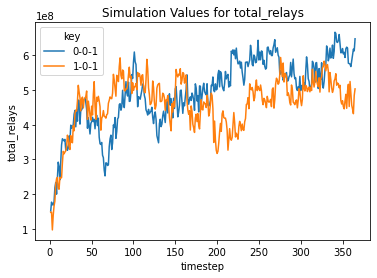

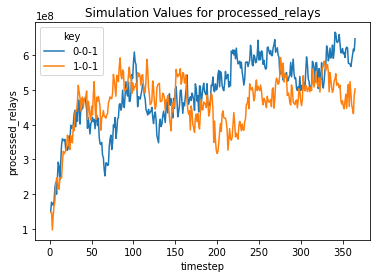

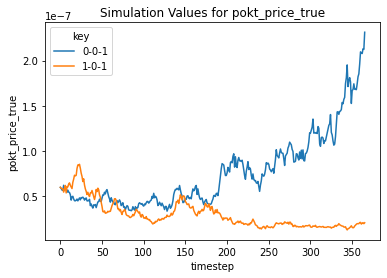

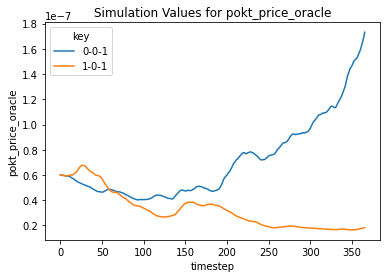

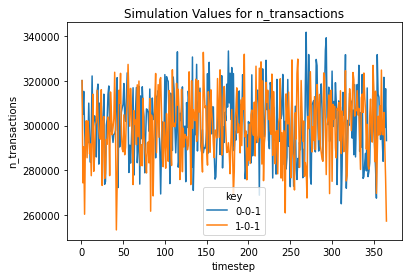

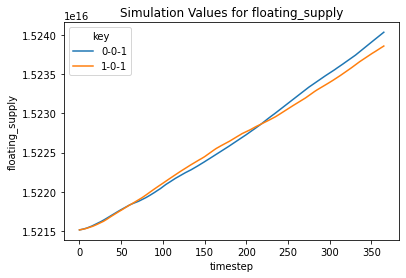

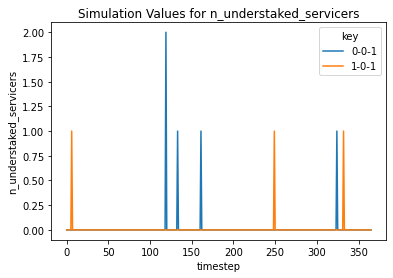

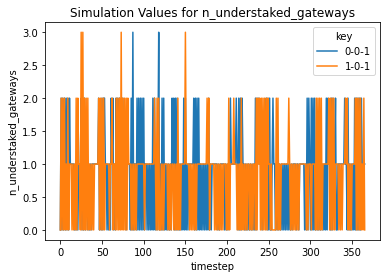

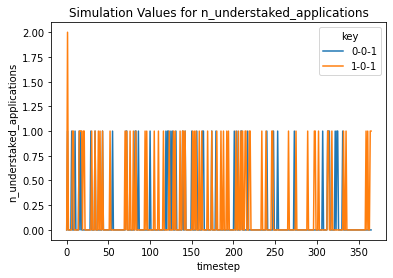

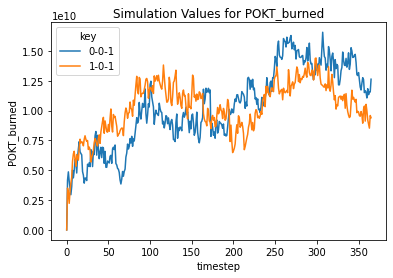

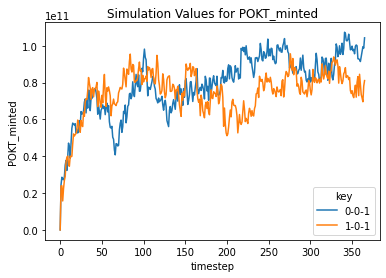

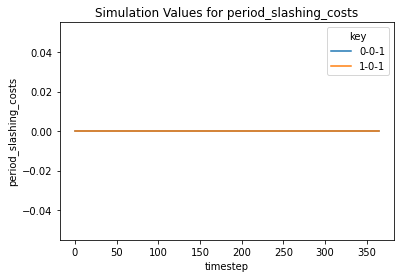

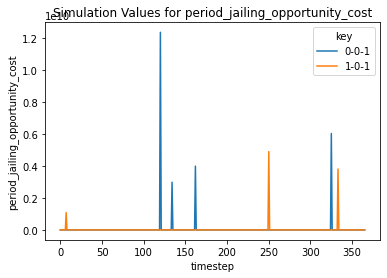

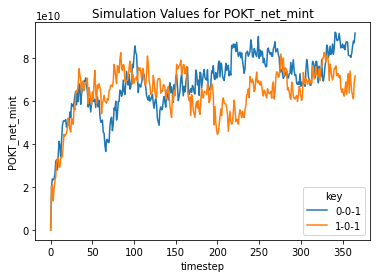

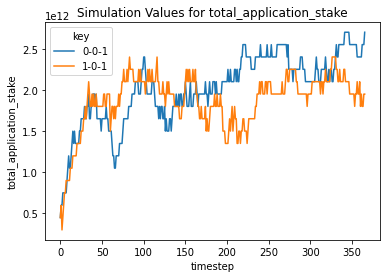

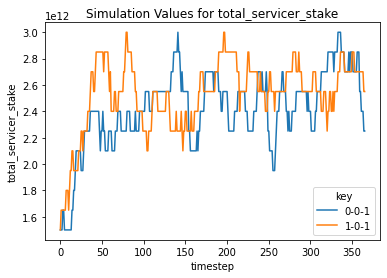

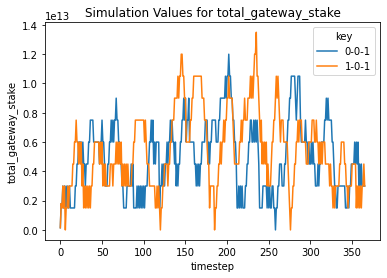

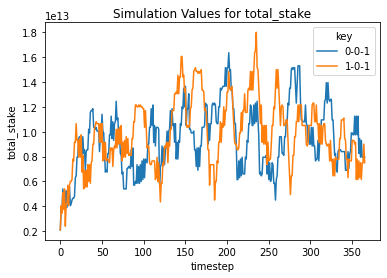

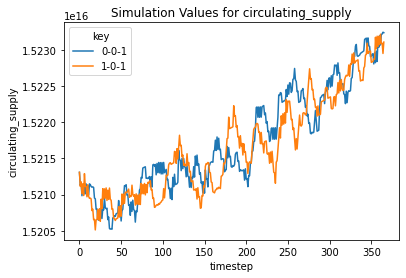

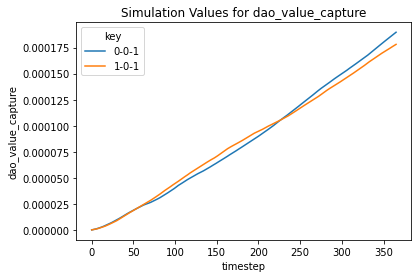

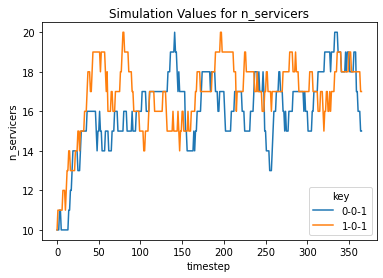

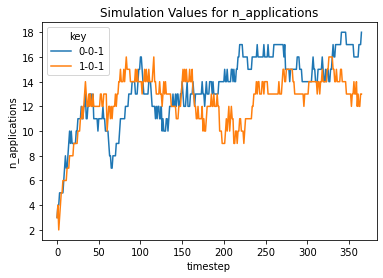

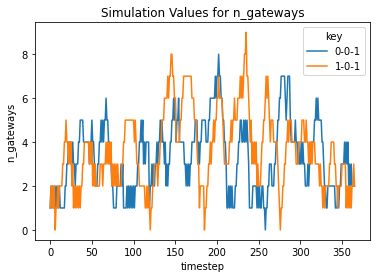

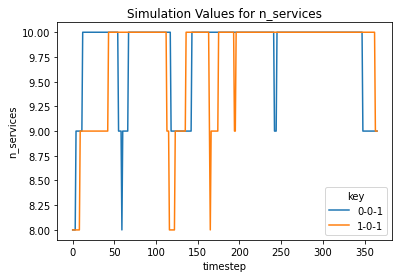

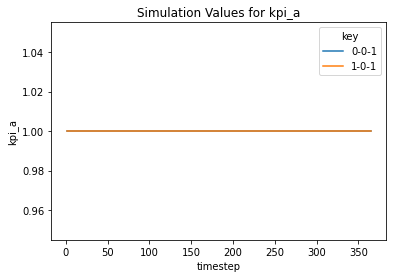

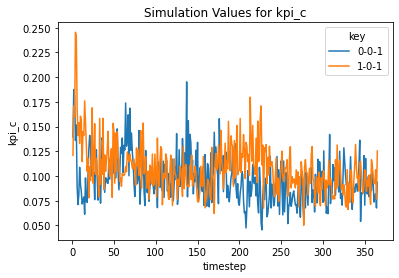

In [2]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services', 'kpi_a', 'kpi_c']:
    # Grab the pivot table
    table = df.pivot("timestep", "key", col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()